In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Required Libraries
!pip install kaggle xgboost scikit-learn pandas matplotlib seaborn

!pip install shap==0.41.0
!pip install numba==0.53.1

# Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, auc
import shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Load Data
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
query = """
SELECT
    p.player_api_id, p.player_name, p.birthday,
    pa.date, pa.overall_rating, pa.potential, pa.preferred_foot,
    pa.attacking_work_rate, pa.defensive_work_rate,
    pa.vision, pa.aggression, pa.positioning,
    pa.acceleration, pa.sprint_speed, pa.stamina, pa.strength,
    pa.dribbling, pa.finishing, pa.short_passing
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE pa.overall_rating IS NOT NULL AND pa.potential IS NOT NULL
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Preprocessing
df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])
latest_df = df.sort_values('date').groupby('player_api_id').last().reset_index()

latest_df['age'] = (latest_df['date'] - latest_df['birthday']).dt.days / 365.25
latest_df['potential_gap'] = latest_df['potential'] - latest_df['overall_rating']

# Apply Constraints
age_cutoff = 24
potential_threshold = 85
filtered_df = latest_df[(latest_df['age'] <= age_cutoff) & (latest_df['potential'] < potential_threshold )].copy()

# Define Underachievers Based on Top Quartile of Potential Gap
threshold = filtered_df['potential_gap'].quantile(0.75)
filtered_df['underachiever'] = (filtered_df['potential_gap'] >= threshold).astype(int)

# Define Features
features = [
    'age', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
    'vision', 'aggression', 'positioning',
    'acceleration', 'sprint_speed', 'stamina', 'strength',
    'dribbling', 'finishing', 'short_passing'
]

X = filtered_df[features].fillna(0)
y = filtered_df['underachiever']

# Encode Categorical Variables
le = LabelEncoder()
for col in ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']:
    X[col] = le.fit_transform(X[col].astype(str))

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Evaluate Models with 5-Fold Stratified Cross-Validation
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    auc_scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='roc_auc')
    print(f"{name} | Mean ROC AUC: {auc_scores.mean():.4f} | Std: {auc_scores.std():.4f}")


Logistic Regression | Mean ROC AUC: 0.8765 | Std: 0.0226
Random Forest | Mean ROC AUC: 0.8751 | Std: 0.0220


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:12:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:12:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:12:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost | Mean ROC AUC: 0.8644 | Std: 0.0207


In [ ]:
# Achievement Distribution
achievement_counts = filtered_df['underachiever'].value_counts()
achievement_percent = filtered_df['underachiever'].value_counts(normalize=True) * 100

print("Achievement Status Distribution:")
print(pd.DataFrame({
    'Count': achievement_counts,
    'Percentage': achievement_percent.round(2)
}))

# Underachiever Rate
underachiever_rate = filtered_df['underachiever'].mean() * 100
print(f"\nUnderachiever Rate: {underachiever_rate:.2f}%")

# Basic Feature Statistics
print("\nFeature Descriptive Statistics:")
print(filtered_df[features].describe().round(2))


Achievement Status Distribution:
               Count  Percentage
underachiever                   
0               4798       67.39
1               2322       32.61

Underachiever Rate: 32.61%

Feature Descriptive Statistics:
           age   vision  aggression  positioning  acceleration  sprint_speed  \
count  7120.00  6874.00     7120.00      7120.00       7120.00       7120.00   
mean     25.21    55.38       59.55        53.52         68.05         68.44   
std       2.99    13.95       16.15        17.87         12.41         12.08   
min      17.03     3.00       11.00         3.00         13.00         12.00   
25%      22.94    47.00       50.00        43.00         62.00         63.00   
50%      25.42    58.00       63.00        58.00         69.00         69.00   
75%      27.81    66.00       72.00        67.00         76.00         76.00   
max      30.00    88.00       92.00        89.00         97.00         96.00   

       stamina  strength  dribbling  finishing  short

In [ ]:
# Achievement Distribution
achievement_counts = filtered_df['underachiever'].value_counts()
achievement_percent = filtered_df['underachiever'].value_counts(normalize=True) * 100

print("Achievement Status Distribution:")
print(pd.DataFrame({
    'Count': achievement_counts,
    'Percentage': achievement_percent.round(2)
}))

# Underachiever Rate
underachiever_rate = filtered_df['underachiever'].mean() * 100
print(f"\nUnderachiever Rate: {underachiever_rate:.2f}%")

# Basic Feature Statistics
print("\nFeature Descriptive Statistics:")
print(filtered_df[features].describe().round(2))


Achievement Status Distribution:
               Count  Percentage
underachiever                   
0               4798       67.39
1               2322       32.61

Underachiever Rate: 32.61%

Feature Descriptive Statistics:
           age   vision  aggression  positioning  acceleration  sprint_speed  \
count  7120.00  6874.00     7120.00      7120.00       7120.00       7120.00   
mean     25.21    55.38       59.55        53.52         68.05         68.44   
std       2.99    13.95       16.15        17.87         12.41         12.08   
min      17.03     3.00       11.00         3.00         13.00         12.00   
25%      22.94    47.00       50.00        43.00         62.00         63.00   
50%      25.42    58.00       63.00        58.00         69.00         69.00   
75%      27.81    66.00       72.00        67.00         76.00         76.00   
max      30.00    88.00       92.00        89.00         97.00         96.00   

       stamina  strength  dribbling  finishing  short

FULL CODE

Achievement Status Distribution:
               Count  Percentage
underachiever                   
0                141       74.21
1                 49       25.79

Underachiever Rate: 25.79%

Feature Descriptive Statistics:
       vision  aggression  positioning  acceleration  sprint_speed  stamina  \
count  190.00      190.00       190.00        190.00        190.00   190.00   
mean    68.57       61.21        64.33         75.66         75.72    71.24   
std     14.96       18.03        23.20         13.34         12.19    14.09   
min     22.00       18.00         4.00         28.00         23.00    25.00   
25%     61.25       48.00        55.25         69.00         69.00    68.00   
50%     72.00       64.50        74.00         78.00         77.50    74.00   
75%     79.00       75.00        80.00         86.00         85.00    79.00   
max     93.00       90.00        94.00         96.00         96.00    93.00   

       strength  dribbling  finishing  short_passing  
count  

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:31:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


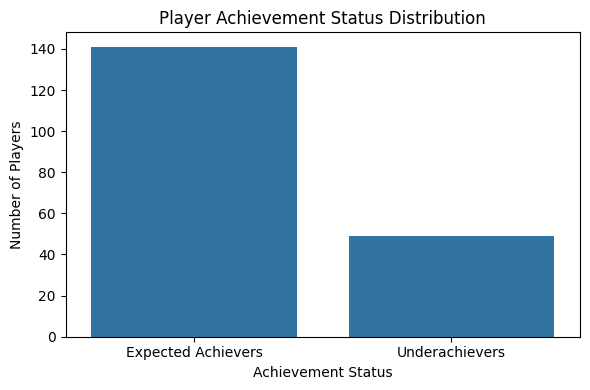

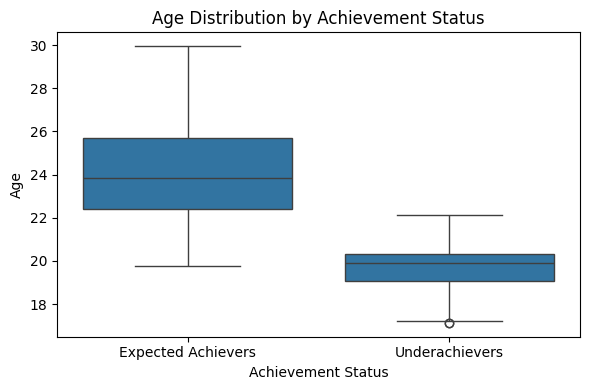

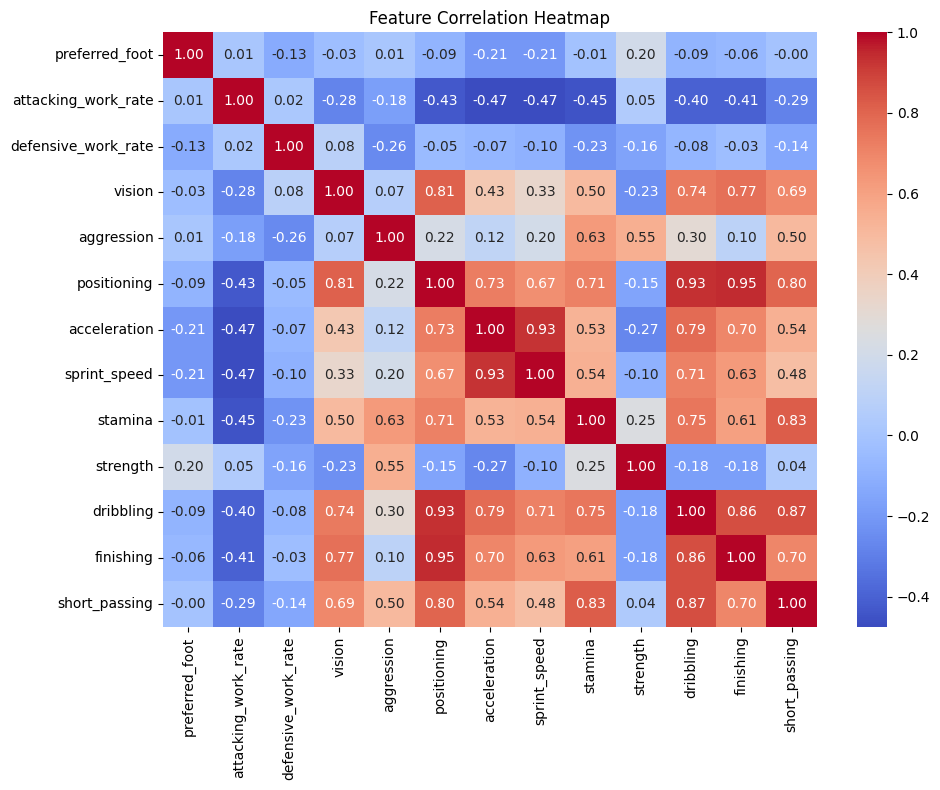

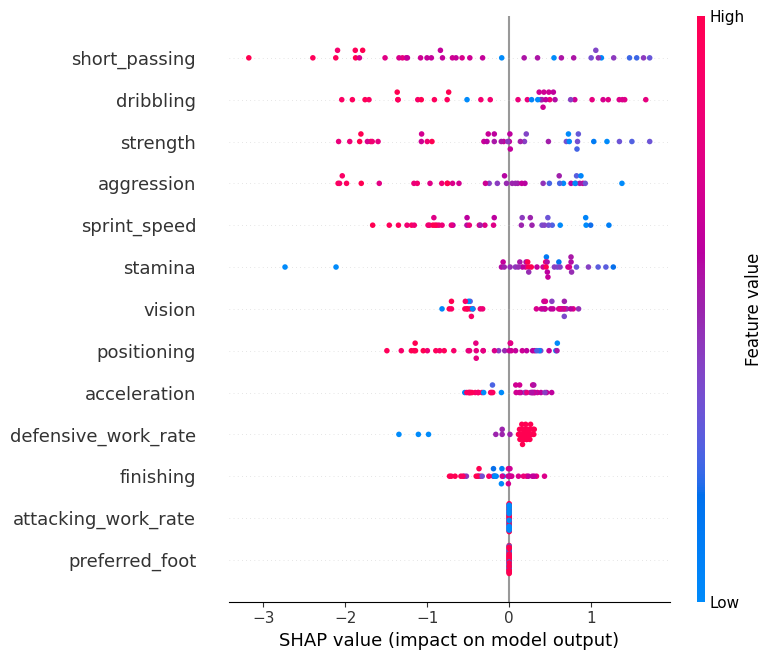

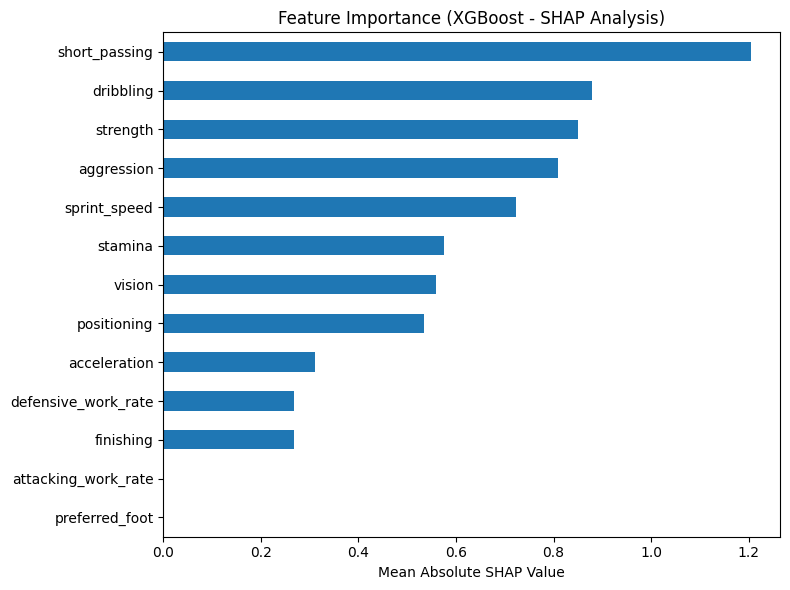

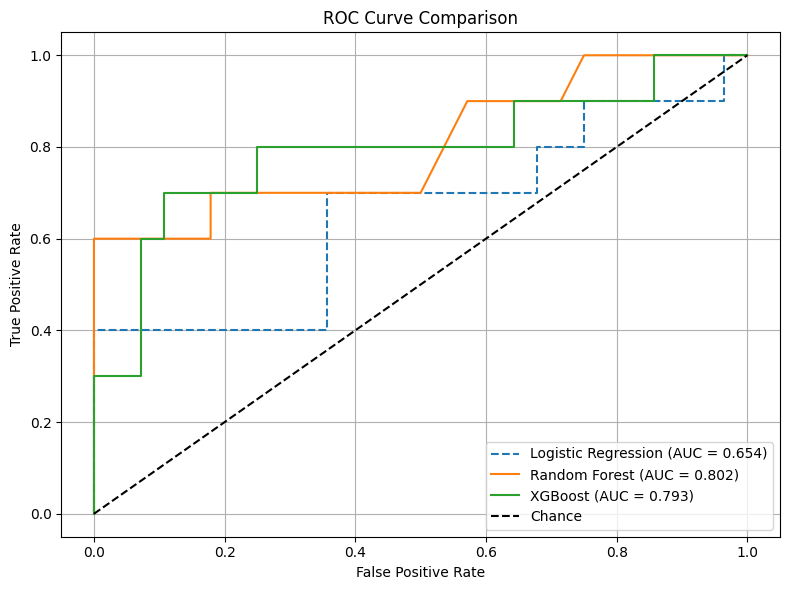

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, auc

# ----------------------
# 1. Load and Preprocess Data
# ----------------------
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
query = """
SELECT
    p.player_api_id, p.player_name, p.birthday,
    pa.date, pa.overall_rating, pa.potential, pa.preferred_foot,
    pa.attacking_work_rate, pa.defensive_work_rate,
    pa.vision, pa.aggression, pa.positioning,
    pa.acceleration, pa.sprint_speed, pa.stamina, pa.strength,
    pa.dribbling, pa.finishing, pa.short_passing
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE pa.overall_rating IS NOT NULL AND pa.potential IS NOT NULL
"""
df = pd.read_sql_query(query, conn)
conn.close()

df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])
latest_df = df.sort_values('date').groupby('player_api_id').last().reset_index()

latest_df['age'] = (latest_df['date'] - latest_df['birthday']).dt.days / 365.25
latest_df['potential_gap'] = latest_df['potential'] - latest_df['overall_rating']

# Apply Constraints
age_cutoff = 30
potential_min = 85
potential_max = 100
#initial_rating_cutoff = 70
#filtered_df = latest_df[(latest_df['age'] <= age_cutoff) & (latest_df['overall_rating'] <= initial_rating_cutoff)].copy()

filtered_df = latest_df[(latest_df['age'] <= age_cutoff) & (latest_df['potential'] >= potential_min) & (latest_df['potential'] <= potential_max)].copy()

threshold = filtered_df['potential_gap'].quantile(0.75)
filtered_df['underachiever'] = (filtered_df['potential_gap'] >= threshold).astype(int)

# features = [
#     'age', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
#     'vision', 'aggression', 'positioning',
#     'acceleration', 'sprint_speed', 'stamina', 'strength',
#     'dribbling', 'finishing', 'short_passing'
# ]

features = [
    'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
    'vision', 'aggression', 'positioning',
    'acceleration', 'sprint_speed', 'stamina', 'strength',
    'dribbling', 'finishing', 'short_passing'
]

X = filtered_df[features].fillna(0)
y = filtered_df['underachiever']

le = LabelEncoder()
for col in ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']:
    X[col] = le.fit_transform(X[col].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------
# 2. Train-Test Split and Model Training
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# ----------------------
# 3. Evaluation and Visualization
# ----------------------
corr_df = filtered_df.copy()
for col in ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']:
    corr_df[col] = le.fit_transform(corr_df[col].astype(str))

# Achievement Distribution
achievement_counts = filtered_df['underachiever'].value_counts()
achievement_percent = filtered_df['underachiever'].value_counts(normalize=True) * 100

print("Achievement Status Distribution:")
print(pd.DataFrame({'Count': achievement_counts, 'Percentage': achievement_percent.round(2)}))

underachiever_rate = filtered_df['underachiever'].mean() * 100
print(f"\nUnderachiever Rate: {underachiever_rate:.2f}%")

print("\nFeature Descriptive Statistics:")
print(filtered_df[features].describe().round(2))

# Plot 1: Achievement Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='underachiever', data=filtered_df)
plt.xticks([0, 1], ['Expected Achievers', 'Underachievers'])
plt.title('Player Achievement Status Distribution')
plt.xlabel('Achievement Status')
plt.ylabel('Number of Players')
plt.tight_layout()
plt.show()

# Plot 2: Age by Achievement
plt.figure(figsize=(6, 4))
sns.boxplot(x='underachiever', y='age', data=filtered_df)
plt.xticks([0, 1], ['Expected Achievers', 'Underachievers'])
plt.title('Age Distribution by Achievement Status')
plt.xlabel('Achievement Status')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

# Plot 3: Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# SHAP Analysis
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

mean_abs_shap = np.abs(np.array(shap_values)).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=features).sort_values()

plt.figure(figsize=(8, 6))
shap_importance.plot(kind='barh')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance (XGBoost - SHAP Analysis)')
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve Comparison
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, '--', label=f'Logistic Regression (AUC = {auc(fpr_lr, tpr_lr):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc(fpr_xgb, tpr_xgb):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

# List all tables
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)
print("Tables in the Database:\n", tables)


Tables in the Database:
                 name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [ ]:
# Example: Inspect features in the Player_Attributes table
player_attributes_query = "PRAGMA table_info('Player_Attributes');"
player_attributes_info = pd.read_sql_query(player_attributes_query, conn)
print("Player_Attributes Features:\n", player_attributes_info[['name']])

# To generalize and list features for all tables:
for table in tables['name']:
    print(f"\nFeatures in Table: {table}")
    info = pd.read_sql_query(f"PRAGMA table_info('{table}');", conn)
    print(info[['name']])


Player_Attributes Features:
                    name
0                    id
1    player_fifa_api_id
2         player_api_id
3                  date
4        overall_rating
5             potential
6        preferred_foot
7   attacking_work_rate
8   defensive_work_rate
9              crossing
10            finishing
11     heading_accuracy
12        short_passing
13              volleys
14            dribbling
15                curve
16   free_kick_accuracy
17         long_passing
18         ball_control
19         acceleration
20         sprint_speed
21              agility
22            reactions
23              balance
24           shot_power
25              jumping
26              stamina
27             strength
28           long_shots
29           aggression
30        interceptions
31          positioning
32               vision
33            penalties
34              marking
35      standing_tackle
36       sliding_tackle
37            gk_diving
38          gk_handling
39         

In [ ]:
match_info = pd.read_sql_query("PRAGMA table_info('Match');", conn)
match_info[['name']].to_csv('/content/drive/MyDrive/Yoni/soccer/match_features.csv', index=False)
print("Exported to match_features.csv")


Exported to match_features.csv


In [ ]:
match_columns = pd.read_sql_query("PRAGMA table_info('Match');", conn)
pd.set_option('display.max_rows', None)
display(match_columns[['name']])


,name
0,id
1,country_id
2,league_id
3,season
4,stage
5,date
6,match_api_id
7,home_team_api_id
8,away_team_api_id
9,home_team_goal


In [ ]:
# Connect to the database
db_path = '/content/drive/MyDrive/Yoni/soccer/database.sqlite'
conn = sqlite3.connect(db_path)

# Get all table names
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)['name'].tolist()

# Collect schema for each table
schema_data = []
for table in tables:
    columns_info = pd.read_sql_query(f"PRAGMA table_info('{table}');", conn)
    for _, row in columns_info.iterrows():
        schema_data.append({
            'Table': table,
            'Column Name': row['name'],
            'Data Type': row['type']
        })

# Create DataFrame and export to CSV
schema_df = pd.DataFrame(schema_data)
csv_path = '/content/drive/MyDrive/Yoni/soccer/database_schema.csv'
schema_df.to_csv(csv_path, index=False)

conn.close()

